### 用tf.data加载图片数据
本教程提供一个如何使用 tf.data 加载图片的简单例子。  
本例中使用的数据集分布在图片文件夹中，一个文件夹含有一类图片  

### 处理流程如下：
+ （1）将数据集下载到本地，不同类别存储在不同文件夹中
+ （2）创建一个列表all_image_labels，包含每个文件的标签索引
+ （3）写函数用tf.io加载图片，用tf.image预处理图片
+ （4）构造一个tf.data.Dataset
+ （5）传递数据集至模型

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "/gpu:1"                  # 添加了"/gpu:1"，在卷积运算时才不会报错！！！！！

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

#### 下载并检查数据集
在你开始任何训练之前，你将需要一组图片来教会网络你想要训练的新类别。你已经创建了一个文件夹，存储了最初使用的拥有创作共用许可的花卉照片。

In [2]:
# 这个数据集一共3600多张，分为daisy,dandelion,roses,sunflower,tulips
# 下载数据集，返回的是存储在本地的、解压后的数据路径
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', 
                                         untar=True)
print(data_root_orig)

# 用pathlib这个包来便捷处理文件夹和文件
import pathlib
data_root = pathlib.Path(data_root_orig)
print(data_root)
type(data_root)

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos


pathlib.PosixPath

In [3]:
for item in data_root.iterdir():
    print(item)
for item in data_root.glob('*/'):
    print(item.name) 

/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/tulips
sunflowers
LICENSE.txt
roses
daisy
dandelion
tulips


In [4]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

#### 检查图片

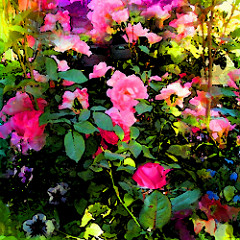

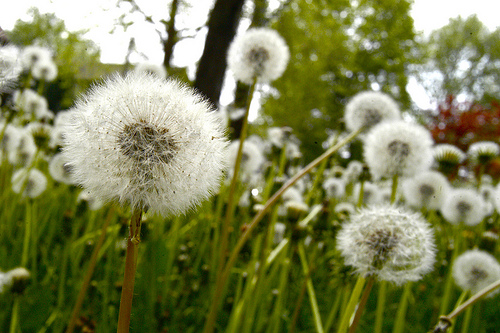

Image (CC BY 2.0)  by brillianthues

Image (CC BY 2.0)  by Maureen Didde



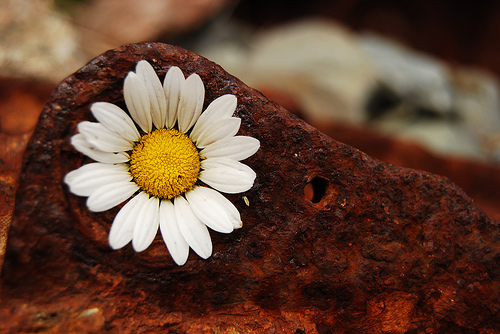

Image (CC BY 2.0)  by Sean McGrath



In [5]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

import IPython.display as display
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

#### 确定每张图片的标签

In [6]:
# 列出可用的标签
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [7]:
# 为每个标签分配索引
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [8]:
# 创建一个列表，包含每个文件的标签索引
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 2, 4, 4, 4, 1, 4, 1, 0, 2]


#### 加载和格式化图片

In [9]:
# 演示第一张图片的加载
img_path = all_image_paths[1]
img_path

img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")
print("img_raw type",type(img_raw))

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\...
img_raw type <class 'tensorflow.python.framework.ops.EagerTensor'>


In [10]:
# 将它解码为图像tensor
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)
print("img_tensor type",type(img_tensor))

(375, 500, 3)
<dtype: 'uint8'>
img_tensor type <class 'tensorflow.python.framework.ops.EagerTensor'>


In [11]:
# 根据你的模型调整其大小
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0
0.9998806


In [12]:
# 将上面的步骤包装在一个简单的函数里，以后备用
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

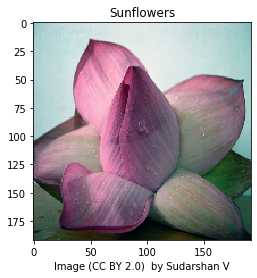

In [13]:
# 以第一张图片为例，看一下图片预处理后是什么样子
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

#### 构建一个tf.data.Dataset
构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。  

In [14]:
# 将字符串数组切片，得到一个字符串数据集
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print(path_ds)

# 现在创建一个新的数据集
# 通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片。
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
print(image_ds)

<TensorSliceDataset shapes: (), types: tf.string>
<ParallelMapDataset shapes: (192, 192, 3), types: tf.float32>


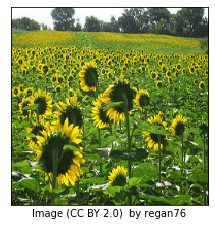

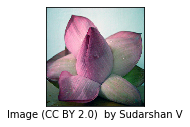

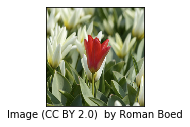

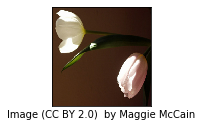

In [15]:
# 看一下结果如何：
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [16]:
# 用同样的方法可以创建一个标签数据集
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(10):
    print(label_names[label.numpy()])

sunflowers
roses
tulips
tulips
tulips
dandelion
tulips
dandelion
daisy
roses


In [17]:
# 由于这两个数据集的顺序相同，可以将其打包成（图片，标签）对数据集
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [18]:
# 将图片和标签数据集写到一块，图片路径做加载和预处理
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

#### 对dataset操作的注意事项：
+ 在 .repeat 之后 .shuffle，会在 epoch 之间打乱数据（当有些数据出现两次的时候，其他数据还没有出现过）
+ 在 .batch 之后 .shuffle，会打乱 batch 的顺序，但是不会在 batch 之间打乱数据。
+ 在完全打乱中使用和数据集大小一样的 buffer_size（缓冲区大小）。较大的缓冲区大小提供更好的随机化，但使用更多的内存，直到超过数据集大小。
+ 在从随机缓冲区中拉取任何元素前，要先填满它。所以当你的 Dataset（数据集）启动的时候一个大的 buffer_size（缓冲区大小）可能会引起延迟。
+ 在随机缓冲区完全为空之前，被打乱的数据集不会报告数据集的结尾。Dataset（数据集）由 .repeat 重新启动，导致需要再次等待随机缓冲区被填满。

In [19]:
# 为数据集在训练时设置一些参数
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

#### 传递数据集至模型
从 tf.keras.applications 取得 MobileNet v2 副本。  
该模型副本会被用于一个简单的迁移学习例子。  
设置 MobileNet 的权重为不可训练：  

In [20]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3),
                                               include_top=False)
mobile_net.trainable = False

# 这是一个keras下.h5格式的模型，包括模型结构和模型参数
print(type(mobile_net))
mobile_net.summary()

<class 'tensorflow.python.keras.engine.training.Model'>
Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________

In [21]:
# help(keras_applications.mobilenet_v2.preprocess_input)

In [22]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [23]:
# MobileNet 为每张图片的特征返回一个 6x6 的空间网格
# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))

print(image_batch.shape)
print(label_batch[0])

(32, 192, 192, 3)
tf.Tensor(3, shape=(), dtype=int32)


In [24]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [25]:
# 构建一个包装了 MobileNet 的模型并,  
# 在 tf.keras.layers.Dense 输出层之前使用 tf.keras.layers.GlobalAveragePooling2D 来平均那些空间向量：

model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

In [26]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.008529104
max logit: 0.8323757

Shape: (32, 5)


In [27]:
# 编译模型以描述训练过程
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

# 此处有两个可训练的变量 —— Dense 层中的 weights（权重） 和 bias（偏差
len(model.trainable_variables)

2

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
model.fit(ds, epochs=1, steps_per_epoch=3)

Train for 3 steps
3/3 [==============================] - 7s 2s/step - loss: 1.8619 - accuracy: 0.2083
